# Đọc dữ liệu ảnh train và test tif và chuyển sang jpg

In [2]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import cv2
from osgeo import ogr
import warnings
from pyproj import Proj, transform
import pickle
import matplotlib
import gc
import os
import matplotlib.image as mpimg

In [3]:
ROOT_FOLDER = "../../"
DATA_FOLDER = "data/field/"
TIF_TRAIN = "Germany.tif"
TIF_TEST = "Germany_test.tif"
SHP_FILE = "field_ger.shp"
POLYGONS_FILE = "polygons.pkl"

In [4]:
def plot(data):
    plt.imshow(data)
    plt.show()

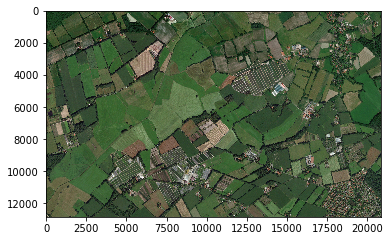

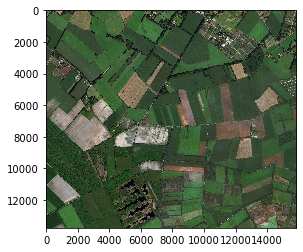

In [20]:

def convert_tif_to_jpg(path, new_name, show = True):
    tif = gdal.Open(path)
    data = []
    for x in range(1, tif.RasterCount+1):
        data.append(tif.GetRasterBand(x).ReadAsArray())
    data = np.array(data)
    data = np.rollaxis(data, 0, 3)
    if show:
        plot(data)
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    cv2.imwrite(new_name, data)

PATH_TIF_TRAIN = os.path.join(ROOT_FOLDER, DATA_FOLDER, TIF_TRAIN)
PATH_TIF_TEST = os.path.join(ROOT_FOLDER, DATA_FOLDER, TIF_TEST)
PATH_SAVE_JPG_TRAIN = os.path.join(ROOT_FOLDER, DATA_FOLDER, "image_train.jpg")
PATH_SAVE_JPG_TEST = os.path.join(ROOT_FOLDER, DATA_FOLDER, "image_test.jpg")


convert_tif_to_jpg(path=PATH_TIF_TRAIN, new_name = PATH_SAVE_JPG_TRAIN, show=True)
convert_tif_to_jpg(path=PATH_TIF_TEST, new_name=PATH_SAVE_JPG_TEST, show=True)

# Lấy toạ độ các polygon dạng pixel

In [26]:
def get_pixel_polygon(path_image_tif, path_shp_file):
    def convert_coordinates_to_geo(corrdinate):
        outProj = Proj(init='epsg:3857')
        inProj = Proj(init='epsg:4326')
        return transform(inProj, outProj, corrdinate[0], corrdinate[1])
    def convert_geo_to_pixel(geo):
        x = int((geo[0] - minx)/resolution_x)
        y = int((geo[1] - miny)/resolution_y)
        return [x, y]
    tif = gdal.Open(path_image_tif)
    shp = ogr.Open(path_shp_file)
    polygons = []
    layer = shp.GetLayer()
    for obj in layer:
        geom = obj.GetGeometryRef().GetGeometryRef(0)
        num_point = geom.GetPointCount()
        P = []
        for point in range(num_point):
            # Lấy kinh độ (longitude) và vĩ độ (latiude), z
            longitude, latitude, _ = geom.GetPoint(point)
            P.append([longitude, latitude])
        polygons.append(np.array(P))
    print("Number of polygon:", len(polygons))
    gt = tif.GetGeoTransform()
    width = tif.RasterXSize
    height = tif.RasterYSize

    resolution_x = gt[1]
    resolution_y = -gt[5]

    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    print(width, height, minx, miny, maxx, maxy, resolution_x, resolution_y)

    warnings.filterwarnings('ignore')

    geo_polygons = []
        
    for polygon in polygons:
        P = []
        for corrdinate in polygon:
            P.append(convert_coordinates_to_geo(corrdinate))
        geo_polygons.append(np.array(P))

    xy_polygons = []
    for polygon in geo_polygons:
        P = []
        for point in polygon:
            P.append(convert_geo_to_pixel(point))
        xy_polygons.append(np.array(P))

    # điều chỉnh lại trục Oy
    polygons = []
    for poly in xy_polygons:
        p = []
        for [x, y] in poly:
            p.append([x, height-y])
        polygons.append(np.array(p))
    return polygons

PATH_IMAGE_SHP = os.path.join(ROOT_FOLDER, DATA_FOLDER, SHP_FILE)
polygons = get_pixel_polygon(PATH_TIF_TRAIN, PATH_IMAGE_SHP)

Number of polygon: 300
20833 12833 874019.3492179187 7029904.384632337 880239.7109767667 7033736.089257273 0.29858214173896963 0.29858214173895303


In [29]:
len(polygons)

300

In [30]:
# lưu lại
with open(os.path.join(ROOT_FOLDER, DATA_FOLDER, POLYGONS_FILE), "wb") as f:
    pickle.dump(polygons, f)

# Cắt ảnh train

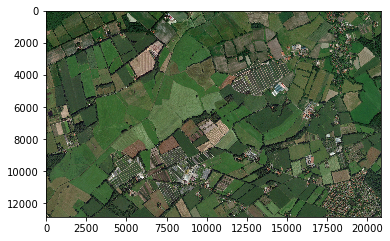

In [5]:
data = cv2.imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, "image_train.jpg"))
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
plot(data)

In [6]:
data.shape

(12833, 20833, 3)

In [7]:
height, width, _ = data.shape

In [8]:
with open(os.path.join(ROOT_FOLDER, DATA_FOLDER, POLYGONS_FILE), "rb") as f:
    polygons = pickle.load(f)
len(polygons)

300

In [9]:
width

20833

In [10]:
height

12833

In [11]:
step = 1024
num_image = 0

for i in range(0, height, step):
    for j in range(0, width, step):
        if i+step<=height and j+step<=width:
            # Tạo ảnh con
            sub_img = data[i:i+step, j:j+step, :]

            # Xem các polygon nào có trong vùng ảnh
            plg = []
            for t in range(len(polygons)):
                for x, y in polygons[t]:
                    if j<=x<=j+step and i<=y<=i+step:
                        plg.append(t)
                        break
            # plt là list chứa các id của polygon mà có vùng nằm trong sub image

            # Tạo mặt nạ [height, width, number polygon] cho các ảnh con
            mask = np.zeros([height, width, len(plg)], dtype=np.uint8)

            for t in range(len(plg)):
                sub_mask = np.zeros([height, width], dtype=np.uint8)
                sub_mask = cv2.fillPoly(sub_mask, [polygons[plg[t]]], 1)
                mask[:,:,t] = sub_mask
            mask = mask[i:i+step, j:j+step, :].astype(np.bool)

            # Lưu ảnh và mặt nạ lại
            matplotlib.image.imsave(os.path.join(ROOT_FOLDER, DATA_FOLDER, "train/", str(num_image)+'.jpg'), sub_img)
            np.save(os.path.join(ROOT_FOLDER, DATA_FOLDER, "mask/", str(num_image)+'.npy'), mask)

            print("Created sub image {}...".format(num_image))
            # giải phóng bộ nhớ
            gc.collect()
            num_image += 1
print("Done!")

Created sub image 0...
Created sub image 1...
Created sub image 2...
Created sub image 3...
Created sub image 4...
Created sub image 5...
Created sub image 6...
Created sub image 7...
Created sub image 8...
Created sub image 9...
Created sub image 10...
Created sub image 11...
Created sub image 12...
Created sub image 13...
Created sub image 14...
Created sub image 15...
Created sub image 16...
Created sub image 17...
Created sub image 18...
Created sub image 19...
Created sub image 20...
Created sub image 21...
Created sub image 22...
Created sub image 23...
Created sub image 24...
Created sub image 25...
Created sub image 26...
Created sub image 27...
Created sub image 28...
Created sub image 29...
Created sub image 30...
Created sub image 31...
Created sub image 32...
Created sub image 33...
Created sub image 34...
Created sub image 35...
Created sub image 36...
Created sub image 37...
Created sub image 38...
Created sub image 39...
Created sub image 40...
Created sub image 41...
Cr

# Test

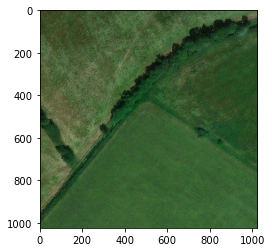

In [12]:
idx = 28
img = mpimg.imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, "train/", str(idx) + '.jpg'))
plot(img)

(1024, 1024, 4)


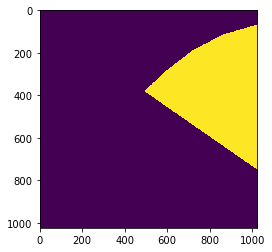

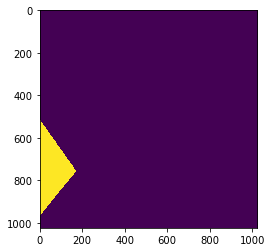

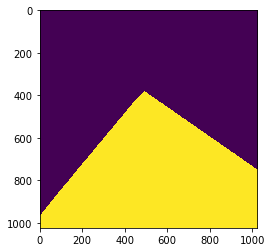

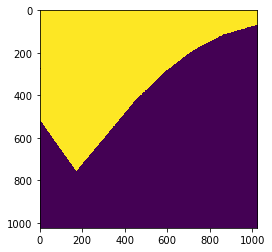

In [13]:
mas = np.load(os.path.join(ROOT_FOLDER, DATA_FOLDER, "mask/", str(idx) + '.npy'))
print(mas.shape)
for i in range(mas.shape[2]):
    plot(mas[:,:,i])

# Cắt ảnh test

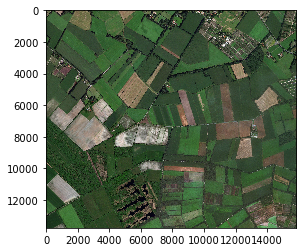

In [14]:
data = cv2.imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, "image_test.jpg"))
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
plot(data)

In [15]:
data.shape

(13761, 15841, 3)

In [16]:
height, width, _ = data.shape

In [17]:
step = 1024
num_image = 0

for i in range(0, height, step):
    for j in range(0, width, step):
        if i+step<=height and j+step<=width:
            # Tạo ảnh con
            sub_img = data[i:i+step, j:j+step, :]
            # Lưu ảnh 
            matplotlib.image.imsave(os.path.join(ROOT_FOLDER, DATA_FOLDER, "test/", str(num_image)+'.jpg'), sub_img)
            print("Created sub image {}...".format(num_image))
            # giải phóng bộ nhớ
            gc.collect()
            num_image += 1
print("Done!")

Created sub image 0...
Created sub image 1...
Created sub image 2...
Created sub image 3...
Created sub image 4...
Created sub image 5...
Created sub image 6...
Created sub image 7...
Created sub image 8...
Created sub image 9...
Created sub image 10...
Created sub image 11...
Created sub image 12...
Created sub image 13...
Created sub image 14...
Created sub image 15...
Created sub image 16...
Created sub image 17...
Created sub image 18...
Created sub image 19...
Created sub image 20...
Created sub image 21...
Created sub image 22...
Created sub image 23...
Created sub image 24...
Created sub image 25...
Created sub image 26...
Created sub image 27...
Created sub image 28...
Created sub image 29...
Created sub image 30...
Created sub image 31...
Created sub image 32...
Created sub image 33...
Created sub image 34...
Created sub image 35...
Created sub image 36...
Created sub image 37...
Created sub image 38...
Created sub image 39...
Created sub image 40...
Created sub image 41...
Cr